# Data Preparation for Sixth Woman

In this notebook we will prepare the data for the Sixth Woman of The Year award prediction.

#### Load Dependencies

In [57]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('..')

from data_scripts import _store_data as sd
from pathlib import Path

sd.load_data(Path("../data"))

#### Copy and Prepare Player Data

This section prepares player performance statistics for Sixth Woman analysis:

- **Copy Dataset:** Create a copy of the original player-team dataset to preserve the source data.  
- **Convert Key Stats to Float:** Ensure important performance statistics are numeric for accurate calculations.  
- **Aggregate by Player and Year:** Group the data by player and year, summing stats to get yearly totals per player.  
- **Add Season 11 Data:** Include additional data from Season 11 for completeness.  
- **Sort Data:** Organize the aggregated data by player and year for multi-year computations.

In [58]:
sixth_players_info_df = sd.players_teams_df.copy()

cols_to_agg = ['points', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'fgMade', 'fgAttempted', 'GP', 'minutes', 'GS']

for col in cols_to_agg:
    sixth_players_info_df[col] = sixth_players_info_df[col].astype(float)

sixth_players_info_df = sixth_players_info_df.groupby(['playerID', 'year'], as_index=False)[cols_to_agg].sum()

# Adding data from Season 11
players_teams_year11_df = pd.read_csv("../basketballPlayoffs/Season_11/players_teams.csv")[['playerID', 'year']]

sixth_players_info_df = pd.concat([sixth_players_info_df, players_teams_year11_df], ignore_index=True)

sixth_players_info_df = sixth_players_info_df.sort_values(['playerID', 'year'])

sixth_aw = sd.awards_players_df.loc[
    sd.awards_players_df['award'].str.strip().str.lower() == 'kim perrot sportsmanship award'
].copy()

sixth_aw['sixth'] = 1

sixth_players_info_df = sixth_players_info_df.merge(
    sixth_aw[['playerID', 'year', 'sixth']],
    on=['playerID', 'year'],
    how='left'
)

sixth_players_info_df['sixth'] = sixth_players_info_df['sixth'].fillna(0).astype(int)


#### Compute Overall Performance Score Function

This section defines a function to calculate an overall performance score for each player per season:

- **Normalize by Games Played:** Adjust statistics to account for differences in games played.  
- **Weight Key Stats:** Apply weights to points, rebounds, assists, steals, blocks, turnovers, and field goal percentage to reflect their impact on overall performance.  
- **Compute Overall Score:** Combine the weighted stats into a single performance score for each player per season.

In [59]:
def overall_performance(PTS, REB, AST, STL, BLK, TOV, FGM, FGA, GP):
    if GP == 0 or FGA == 0:
        return 0 
    FG_percent = FGM / FGA
    return (
        (PTS / GP) +
        (REB / GP) * 1.2 +
        (AST / GP) * 1.5 +
        (STL / GP) * 3 +
        (BLK / GP) * 2 -
        (TOV / GP) * 2 +
        FG_percent * 10
    )


#### Calculate Multi-Year Performance Scores

This section computes multi-year performance scores for each player:

- **Previous Seasons:** Calculate performance scores for the past 1, 2, and 3 years.  
- **Use `overall_performance` Function:** Apply the function to generate per-season performance scores.  
- **Create Lagged Features:** Generate lagged statistics to capture trends over multiple seasons, useful for predictive modeling.

In [60]:
for shift_years in [1, 2, 3]:
    col_suffix = f"prev_{shift_years}yr"

    
    shifted_points = sixth_players_info_df.groupby('playerID')['points'].shift(shift_years)
    shifted_assists = sixth_players_info_df.groupby('playerID')['assists'].shift(shift_years)
    shifted_turnovers = sixth_players_info_df.groupby('playerID')['turnovers'].shift(shift_years)
    shifted_fgMade = sixth_players_info_df.groupby('playerID')['fgMade'].shift(shift_years)
    shifted_fgAttempted = sixth_players_info_df.groupby('playerID')['fgAttempted'].shift(shift_years)
    shifted_gp = sixth_players_info_df.groupby('playerID')['GP'].shift(shift_years)
    shifted_rebounds = sixth_players_info_df.groupby('playerID')['rebounds'].shift(shift_years)
    shifted_steals = sixth_players_info_df.groupby('playerID')['steals'].shift(shift_years)
    shifted_pf = sixth_players_info_df.groupby('playerID')['blocks'].shift(shift_years)

    
    overall_performance_scores = pd.Series(
        [overall_performance(
            shifted_points.iloc[i], shifted_rebounds.iloc[i], shifted_assists.iloc[i],
            shifted_steals.iloc[i], shifted_pf.iloc[i], shifted_turnovers.iloc[i],
            shifted_fgMade.iloc[i], shifted_fgAttempted.iloc[i], shifted_gp.iloc[i])
         for i in range(len(sixth_players_info_df))],
        index=sixth_players_info_df.index
    )
    
    sixth_players_info_df[f'overall_score_{col_suffix}'] = overall_performance_scores.fillna(0)

#### Calculate Player Usage by Game Started Ranges

This section categorizes players based on their starting status in the previous season:

- **Previous Games and Starts:** Retrieve games played and started from the prior year.  
- **Calculate Start Percentage:** Compute the proportion of games started.  
- **Categorize Usage:** Bin the percentage into categories to indicate bench vs. starter roles.  
- **Add Feature:** Include this as a feature for modeling Sixth Woman eligibility.

In [61]:
sixth_players_info_df['GP_prev_year'] = (
    sixth_players_info_df.groupby('playerID')['GP'].shift(1)
).fillna(0).astype(int)

sixth_players_info_df['GS_prev_year'] = (
    sixth_players_info_df.groupby('playerID')['GS'].shift(1)
).fillna(0).astype(int)

sixth_players_info_df['GS_prev_pct'] = np.where(
    sixth_players_info_df['GP_prev_year'] == 0,
    0,
    sixth_players_info_df['GS_prev_year'] / sixth_players_info_df['GP_prev_year']
)

sixth_players_info_df['GS_category'] = pd.cut(
    sixth_players_info_df['GS_prev_pct'],
    bins=[0, 0.8, 1],
    labels=[0, 1],
    include_lowest=True
)

#### Remove Columns and Save CSV

This step finalizes the Sixth Woman dataset:

- **Drop Unnecessary Columns:** Remove raw stats and irrelevant features to focus on key data.  
- **Save to CSV:** Export the processed dataset to a CSV file for predictive modeling.  
- **Ready for Analysis:** The dataset is now clean and contains features for Sixth Woman award prediction.

In [62]:
column_order = [
    'playerID',
    'year',
    'overall_score_prev_1yr',
    'overall_score_prev_2yr',
    'overall_score_prev_3yr',
    'GS_category',
    'sixth'
]
sixth_players_info_df = sixth_players_info_df[column_order]

sixth_players_info_df.to_csv("../predict_datasets/swoty.csv", index=False)

#### Idea For the Dataset Preparation

Since this is the Sixth Woman of the Year dataset, we calculated the overall performance score for each player to evaluate their general level of play.

We also added a games started category to help account for a player’s typical role. Established starters are considered less likely to win the award, as they are rarely moved into a sixth woman role the following season, though it remains a possibility.

This approach helps refine the candidate pool, as the award has historically favored players who had more limited playing time in prior seasons.

#### Data Correlation Analysis

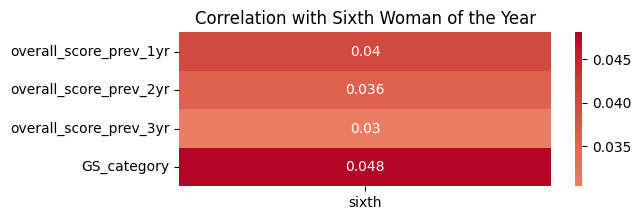

In [63]:
score_cols = ['overall_score_prev_1yr', 'overall_score_prev_2yr', 'overall_score_prev_3yr', 'GS_category', 'sixth']
df_scores = sixth_players_info_df[score_cols]

corr_matrix = df_scores.corr()[['sixth']]

corr_matrix = corr_matrix.drop('sixth')

plt.figure(figsize=(6, len(corr_matrix)/2))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation with Sixth Woman of the Year")
plt.show()